<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

#### **Import Libraries**

In [1]:
import os 
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from tqdm import tqdm
import numpy as np 
import random 
import math
from itertools import chain
from IPython.display import display, Markdown
import textwrap
import tiktoken
import csv
import time 
import pandas as pd 
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DataCollatorWithPadding
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict
import seaborn as sns 
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import optax 
from trics.regression.data import Data 
from trics.regression.est import iv 
%config InlineBackend.figure_format = 'retina'  # For better quality figures
import warnings
warnings.filterwarnings('ignore', message=".*not a recognized feature for this target.*", category=UserWarning)

#### **Parameters**

In [2]:
seed = 1
noise = False 
sample_size = 5000 
version = 4

In [3]:
# Parameters
noise = False
seed = 2546248239
version = 4
sample_size = 1000


#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_9pt/Newsreader_9pt-Bold.ttf


#### **First Stage Function**

In [7]:
def fstage(var0, var1, var2, var3, var4):
    return 0.2*(var3 >= 3) + 0.3*var4 + 0.2*(var3 >= 3)*var4

#### **Read in Data**

In [8]:
# Read in Data Set
df = pd.read_csv(data_csv)

# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'],
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + np.random.normal(size=sample_size)

df = pd.get_dummies(df, columns=['Var0', 'Var1', 'Var3', 'Var4'], drop_first=True)

#### **Plot**

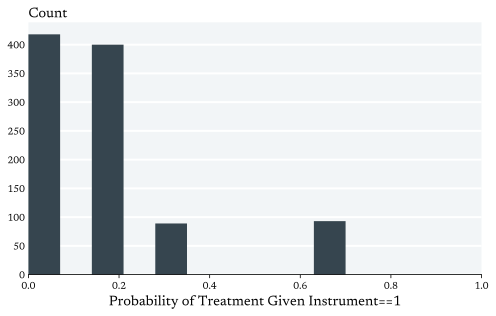

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument==1', size=14)
plt.show()

In [10]:
# Select columns that start with 'Var'
var_columns = [col for col in df.columns if col.startswith('Var')]

# Create a numpy matrix from the selected columns
X = df[var_columns].to_numpy().astype(float)

D = jnp.array(df['Treatment'].values.reshape(-1,1)).astype(float)
Z = jnp.array(df['Instrument'].values.reshape(-1,1)).astype(float)
Y = jnp.array(df['Outcome'].values.reshape(-1,1))
X = jnp.hstack((jnp.ones_like(Z), X))

2024-06-20 15:41:14.898230: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a reco

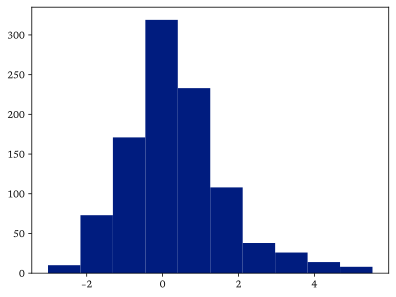

In [11]:
plt.hist(Y.reshape(-1,))
plt.show()

#### **Generate Outcome Data**

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
est = iv(Data(X, D, Y, Z))
df_estimate = pd.DataFrame({'Estimate': est})
est

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


RuntimeError: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

#### **Save Results**

In [ ]:
# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/linear_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_estimate[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_estimate[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)